<a href="https://colab.research.google.com/github/Kevin-Perdomo/Rede_Neural_Artificial/blob/main/Classifica%C3%A7%C3%A3o_de_Raios_X_com_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 ETAPA 0 – Classificação de Raios-X com CNN


# 📊 Classificação de Raios-X com CNN

Este notebook treina uma Rede Neural Convolucional (CNN) para classificar imagens de raios-X nas categorias:

- (0) **Covid-19**
- (1) **Normal**
- (2) **Pneumonia Viral**
- (3) **Pneumonia Bacteriana**

Cada imagem é uma radiografia do tórax e o objetivo é realizar diagnóstico assistido por IA.


# 📁 ETAPA 1 – Importação das Bibliotecas

In [168]:
# Verifique a versão do TensorFlow (Colab geralmente já tem a versão 2.x instalada)
import tensorflow as tf
print(f"Versão do TensorFlow: {tf.__version__}")
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Importando o ModelCheckpoint para salvar o modelo durante o treinamento
from tensorflow.keras.callbacks import ModelCheckpoint

print("\nTodas as bibliotecas foram importadas com sucesso!")

Versão do TensorFlow: 2.18.0

Todas as bibliotecas foram importadas com sucesso!


In [169]:
# Exibe informações sobre a GPU NVIDIA, como uso de memória, temperatura, e processos em execução
!nvidia-smi

Sun Jul 20 18:22:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             34W /   70W |    2190MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🔗 ETAPA 2 – Conectar ao Google Drive

In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 📂 ETAPA 3 – Definir Caminho e Estrutura dos Dados

In [171]:
# Caminho onde estão as pastas com as imagens organizadas por classe
dataset_path = '/content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/Departamento médico'
train_dir = '/content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/Departamento médico/Dataset'
test_dir = '/content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/Departamento médico/Test'
weights_path = '/content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/weights.keras'

# 🧾 ETAPA 4 – Carregamento dos Dados

In [172]:
img_size = (180, 180)
batch_size = 32

# Carrega imagens de treino
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Carrega imagens de teste
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Salva os nomes das classes
class_names = train_ds.class_names
print("Classes:", class_names)

Found 532 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Classes: ['0', '1', '2', '3']


# 🚀 ETAPA 5 – Otimização do pipeline

In [173]:
AUTOTUNE = tf.data.AUTOTUNE                                               # Define o AUTOTUNE para otimizar o pré-processamento automaticamente
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # Cacheia os dados, embaralha com um buffer de 1000 e pré-carrega de forma otimizada
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)                    # Cacheia os dados de validação e pré-carrega de forma otimizada

# 🖼️ ETAPA 6 – Visualização de Imagens de Treinamento

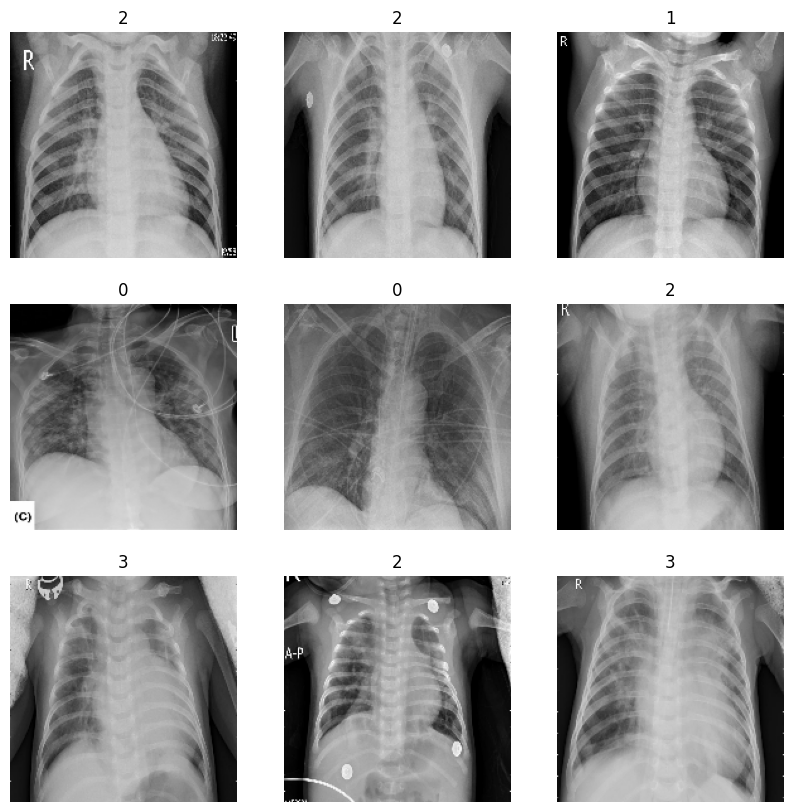

In [174]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 🧠 ETAPA 7 – Construção do Modelo CNN

In [175]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),               # Entrada da imagem (180x180 RGB)
    tf.keras.layers.Rescaling(1./255),                 # Normaliza pixels de 0–255 para 0–1

    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # Extrai padrões simples (32 filtros 3x3)
    tf.keras.layers.MaxPooling2D(),                    # Reduz dimensões mantendo informacao essencial

    tf.keras.layers.Conv2D(64, 3, activation='relu'),  # Extrai padrões mais complexos
    tf.keras.layers.MaxPooling2D(),                    # Reduz ainda mais a resolução

    tf.keras.layers.Conv2D(128, 3, activation='relu'), # Extrai formas e estruturas abstratas
    tf.keras.layers.MaxPooling2D(),                    # Compacta para reduzir custo computacional

    tf.keras.layers.Flatten(),                         # Achata os dados 2D em vetor 1D para a parte densa
    tf.keras.layers.Dense(128, activation='relu'),     # Camada densa para tomada de decisão
    tf.keras.layers.Dropout(0.3),                      # Dropout: evita overfitting desativando neurônios aleatoriamente
    tf.keras.layers.Dense(4, activation='softmax')     # Saída com 4 neurônios (uma para cada classe), com softmax (probabilidades)
])

In [176]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

# ⚙️ ETAPA 8 – Compilar o Modelo

In [177]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

 # 📥 ETAPA 9 – Callback para salvar o melhor modelo

In [178]:
# ✅ Definir o callback que salva apenas os melhores pesos com base na menor perda (loss)
checkpoint = ModelCheckpoint(
    filepath=weights_path,
    monitor='val_accuracy',  # ✅ Monitorar a acurácia no conjunto de validação
    verbose=1,
    save_best_only=True,
    mode='max'               # ✅ Queremos a maior acurácia possível
)

# 🔁 Lista de callbacks para o model.fit
callbacks_list = [checkpoint]

# 🏋️ ETAPA 10 – Treinar o Modelo

In [179]:
# Número de épocas para o treinamento
epochs = 600

# 🧠 Treinar o modelo com o callback ativado
history = model.fit(
    train_ds,                         # Dados de treinamento
    validation_data=val_ds,           # Dados de validação
    epochs=epochs,                    # Número de épocas
    callbacks=callbacks_list,         # ⬅️ Lista de callbacks (ModelCheckpoint)
    verbose=1                         # Mostra progresso em tempo real no terminal
)

Epoch 1/600
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3346 - loss: 1.6405
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/weights.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.3387 - loss: 1.6270 - val_accuracy: 0.6000 - val_loss: 0.9885
Epoch 2/600
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6827 - loss: 0.7995
Epoch 2: val_accuracy improved from 0.60000 to 0.67500, saving model to /content/drive/MyDrive/Classroom/IA na Prática/ANN_CNN/weights.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6860 - loss: 0.7902 - val_accuracy: 0.6750 - val_loss: 0.7406
Epoch 3/600
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7843 - loss: 0.5894
Epoch 3: val_accuracy did not improve from 0.67500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7878 - loss: 0.5844 - val_accuracy: 0.6500 - val_loss: 0.7456
Epoch 4/600
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy

# 📈 ETAPA 11 – Avaliação Final

In [180]:
# Carrega os melhores pesos salvos automaticamente durante o treinamento
model.load_weights(weights_path)

loss, acc = model.evaluate(val_ds)
print(f"Acurácia: {acc*100:.2f}%, Perda: {loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8375 - loss: 4.2800
Acurácia: 85.00%, Perda: 3.9524


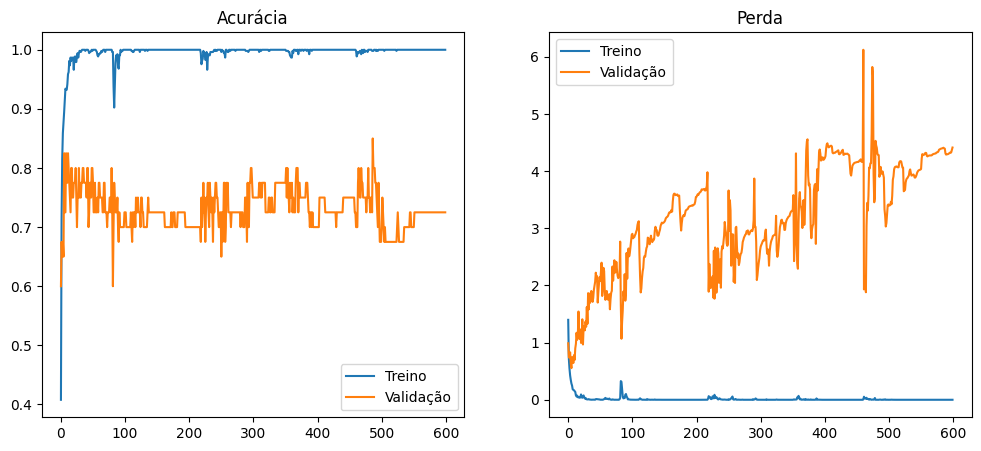

In [181]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Perda')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


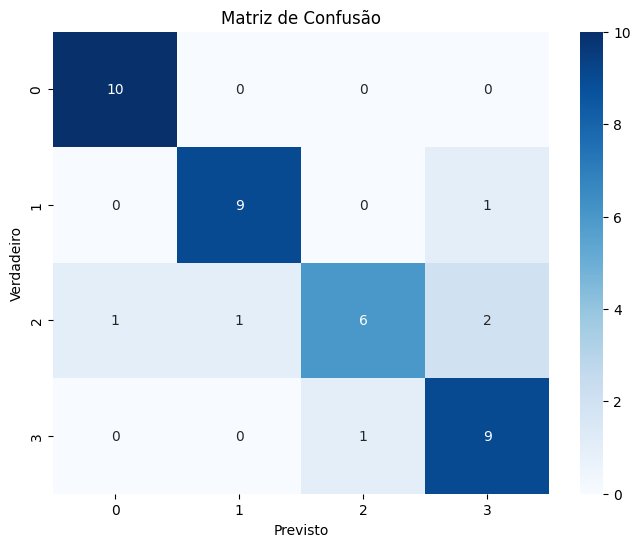

In [182]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obter previsões
y_pred = []
y_true = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

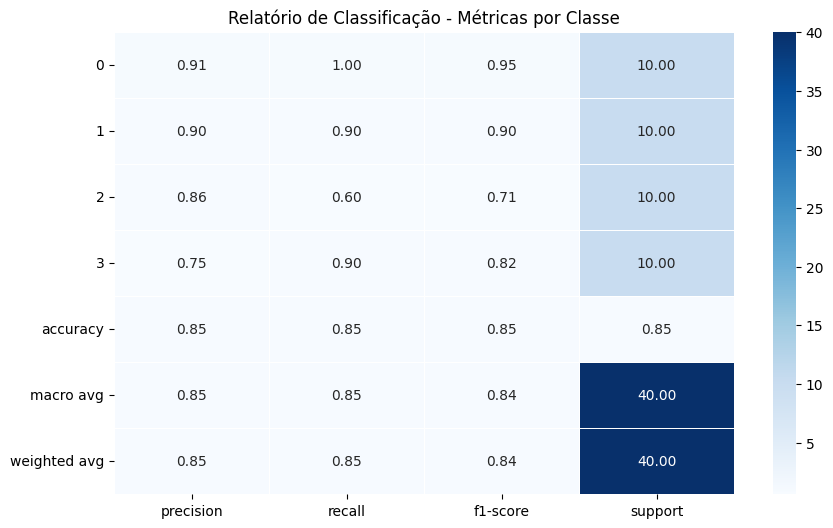

In [183]:
# Gerar o relatório de classificação
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Converter o relatório para um DataFrame
report_df = pd.DataFrame(report).transpose()

# Verificar se 'accuracy' está presente e removê-la, caso exista
if 'accuracy' in report_df.columns:
    report_df = report_df.drop('accuracy', axis=1)

# Plotando a tabela do relatório de classificação
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.astype(float), annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Relatório de Classificação - Métricas por Classe')
plt.show()

# ✅ 📤 ETAPA 12 (FINAL) – Desmontar o Google Drive

In [184]:
# Encerra a conexão com o Google Drive
# Garante que todas as alterações sejam salvas corretamente
#drive.flush_and_unmount()